In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MiCM2021-PKD/beta/
my_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/'

/content/drive/MyDrive/MiCM2021-PKD/beta


In [3]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 4.2MB/s 


In [4]:
!pip install tqdm

In [5]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import torch.optim as optim
import os
from UNET import UNET
from dataset import SliceDataset
import torch
import math
from DiceLoss import myDiceLoss
from transform import transforms
from utils import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy
)
import time



In [6]:
def train_fn(train_dataloader, model, optimizer, loss_fn, scaler):
    loop = tqdm(train_dataloader, position=0, leave=True)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.unsqueeze(1).to(device=DEVICE)

        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            # print("pred: ", predictions.shape)
            loss = loss_fn.forward(predictions, targets)
            # loss = loss_fn(predictions, targets)
            # print("loss: ", loss.shape)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOAD_MODEL = False

In [10]:

my_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/MR2D/Train'
img_paths = []
for dcm in os.listdir(my_dir + '/X'):
    if dcm != ".DS_Store":
        img_paths.append(my_dir + '/X/' + dcm)
img_paths.sort()

seg_paths = []
for seg in os.listdir(my_dir + '/Y'):
    if seg != ".DS_Store":
        seg_paths.append(my_dir + '/Y/' + seg)
seg_paths.sort()

    # Train = ds.SliceDataset(img_paths, seg_paths)
train_idx = random.sample(range(0, len(img_paths)), math.ceil(0.75*len(img_paths)))
train_img_paths = []
train_seg_paths = []
val_img_paths = []
val_seg_paths = []
for idx in range(len(img_paths)):
    if idx in train_idx:
        train_img_paths.append(img_paths[idx])
        train_seg_paths.append(seg_paths[idx])
    else:
        val_img_paths.append(img_paths[idx])
        val_seg_paths.append(seg_paths[idx])
Train = SliceDataset(train_img_paths, train_seg_paths, transform=transforms(0.5, 0.5))
Val = SliceDataset(val_img_paths, val_seg_paths, transform=transforms(0.5, 0.5))


val_losses = []
dice_scores = []
UNet = UNET(in_channels=1, out_channels=1).to(DEVICE)
    # loss_fn = nn.BCEWithLogitsLoss()
loss_fn = myDiceLoss()
optimizer = optim.Adam(UNet.parameters(), lr=2 * 1e-3)
train_loader, val_loader = get_loaders(Train, Val)
    # check_accuracy(val_loader, UNet, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

NUM_EPOCHS = 10

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), UNet)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print("Epoch: {epoch}/{total}".format(epoch=epoch + 1, total=NUM_EPOCHS))
    train_fn(train_loader, UNet, optimizer, loss_fn, scaler)

        # save model
    checkpoint = {
        "state_dict": UNet.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

        # check accuracy
    loss, dice = check_accuracy(val_loader, UNet, loss_fn, device=DEVICE)
    val_losses.append(loss)
    dice_scores.append(dice)
        # # print some examples to a folder
        # save_predictions_as_imgs(
        #     val_loader, model, folder="saved_images/", device=DEVICE
        # )
print("--- Training time: %s seconds ---" % (time.time() - start_time))
save_checkpoint(checkpoint)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/32 [00:00<?, ?it/s]

Got 12784148/12800000 with acc 99.88
Dice score: 0.9723546504974365
Epoch: 2/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12790272/12800000 with acc 99.92
Dice score: 0.9830722808837891
Epoch: 3/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799400/12800000 with acc 100.00
Dice score: 0.9989776015281677
Epoch: 4/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799773/12800000 with acc 100.00
Dice score: 0.999636173248291
Epoch: 5/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799790/12800000 with acc 100.00
Dice score: 0.9996606707572937
Epoch: 6/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799871/12800000 with acc 100.00
Dice score: 0.9997941255569458
Epoch: 7/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799927/12800000 with acc 100.00
Dice score: 0.9998841881752014
Epoch: 8/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799951/12800000 with acc 100.00
Dice score: 0.9999212026596069
Epoch: 9/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799968/12800000 with acc 100.00
Dice score: 0.9999443888664246
Epoch: 10/10


100%|██████████| 32/32 [01:05<00:00,  2.04s/it, loss=0.00579]


Got 12799967/12800000 with acc 100.00
Dice score: 0.9999461770057678
=> Saving checkpoint


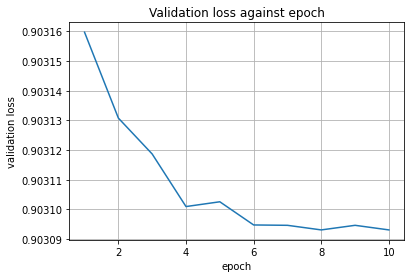

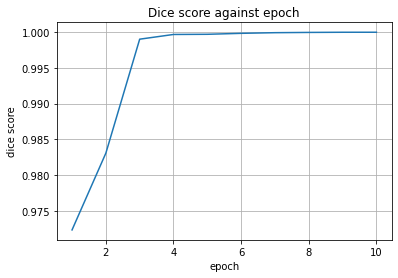

In [13]:
import matplotlib.pyplot as plt

m_loss=[]
for loss in val_losses:
  m_loss.append(float(loss.cpu()))

m_dice=[]
for dice in dice_scores:
  m_dice.append(float(dice.cpu()))

t = [i for i in range(1,NUM_EPOCHS+1)]


fig, ax = plt.subplots()
ax.plot(t, m_loss)

ax.set(xlabel='epoch', ylabel='validation loss',
       title='Validation loss against epoch')
ax.grid()

plt.show()


fig, ax = plt.subplots()
ax.plot(t, m_dice)

ax.set(xlabel='epoch', ylabel='dice score',
       title='Dice score against epoch')
ax.grid()

plt.show()

In [ ]:
def test(loader, model, loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            # print("x: ", x.shape)
            # print("y: ", y.shape)
            x = x.unsqueeze(1).to(device)
            # print("x: ", x.shape)
            y = y.unsqueeze(1).to(device)
            # print("mo la")
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            loss = loss_fn.forward(preds,y)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    return loss, dice_score/len(loader)

In [14]:
def save_predictions_as_imgs(
    loader, model, device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        # torchvision.utils.save_image(
        #     preds, f"{folder}/pred_{idx}.png"
        # )
        # torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")
    # print(type(preds))
    # print(preds.shape)
    model.train()
    return preds

In [79]:
test_img_paths = []
test_seg_paths = []
test_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/MR2D/Test'
for dcm in os.listdir(test_dir + '/X'):
    if dcm != ".DS_Store":
        test_img_paths.append(test_dir + '/X/' + dcm)
test_img_paths.sort()

for seg in os.listdir(test_dir + '/Y'):
    if seg != ".DS_Store":
        test_seg_paths.append(test_dir + '/Y/' + seg)
test_seg_paths.sort()


test_idx = random.sample(range(0, len(test_img_paths)), 10)

sampled_test_img_paths = []
sampled_test_seg_paths = []

for idx in test_idx:
  sampled_test_img_paths.append(test_img_paths[idx])
  sampled_test_seg_paths.append(test_seg_paths[idx])

Test = SliceDataset(sampled_test_img_paths, sampled_test_seg_paths, transform=None)
test_loader = DataLoader(Test,1)

loop = tqdm(test_loader, position=0, leave=True)

preds = []
ground = []

for batch_idx, (data, targets) in enumerate(loop):
    data = data.unsqueeze(1).to(device=DEVICE)


    pred = torch.sigmoid(UNet(data))
    pred = (pred > 0.5).float()

    preds.append(pred.detach().cpu().numpy()[0][0])

    targets = targets.float().unsqueeze(1).to(device=DEVICE)
    ground.append(targets.detach().cpu().numpy()[0][0])


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [80]:
ground[0].shape

(320, 320)

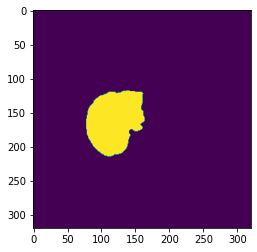

In [81]:
plt.imshow(ground[0])

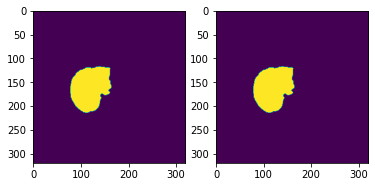

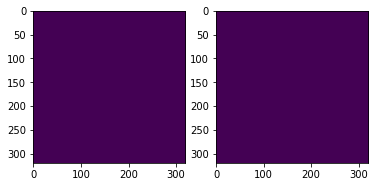

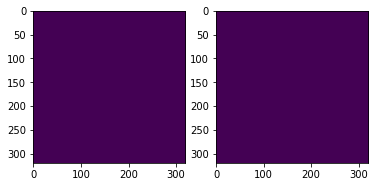

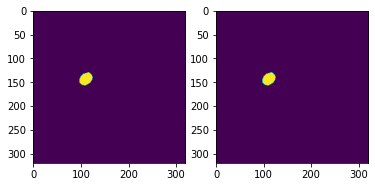

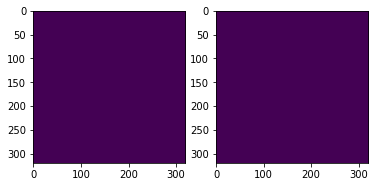

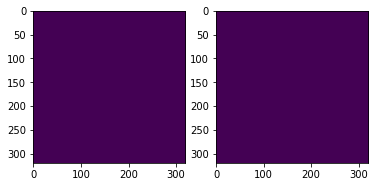

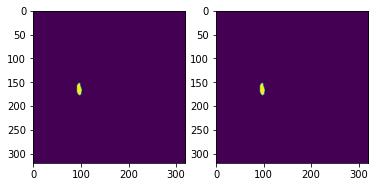

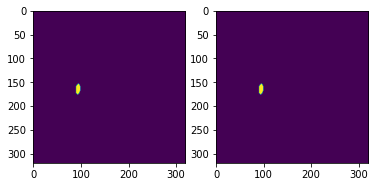

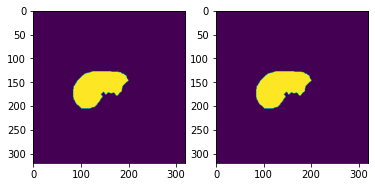

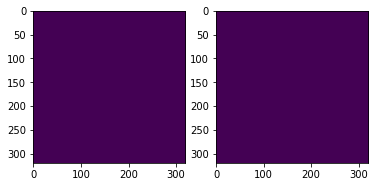

In [82]:
for idx in range(len(preds)):

  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(ground[idx])
  axarr[1].imshow(preds[idx])
# for idx in range(len(preds)):
#   axarr[idx, idx%2].imshow(preds[idx])
#   axarr[idx, idx%2].imshow(ground[idx])

In [86]:
Test_total = SliceDataset(test_img_paths, test_seg_paths, transform=None)
test_total_loader = DataLoader(Test_total,1)



In [87]:
loss, dice = check_accuracy(test_total_loader, UNet, loss_fn, device=DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Got 12595152/12595200 with acc 100.00
Dice score: 0.6828561425209045


In [99]:
tot = 0
count = 0
perfect = True
for idx in range(len(preds)):
  for r in range(len(preds[idx])):
    for c in range(len(preds[idx][r])):
      count += 2
      if preds[idx][r][c] == ground[idx][r][c]:
        tot +=1
      else:
        perfect = False

print(f"dice coeff {2*tot/count:.10f}")
print(perfect)
print(tot)

dice coeff 1.0000000000
True
1024000


In [69]:
import numpy as np

In [78]:
np.amax(ground[0])

1.0

In [84]:
len(test_loader)

10